<a href="https://colab.research.google.com/github/toyokawaxyz/forex/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from scipy.stats import norm
from sklearn.model_selection import train_test_split,TimeSeriesSplit, GridSearchCV
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
%matplotlib inline



In [ ]:
df_train = pd.read_csv("/content/drive/My Drive/usdjpy2000_2018_all.csv")
df_test= pd.read_csv("/content/drive/My Drive/usdjpy2019_all.csv")
ramuda = 0.94
a = 0.95

In [ ]:
#列名の変更（トレインデータ）
train_a=df_train.rename(columns={"USD/JPY High": "High","USD/JPY Low": "Low","USD/JPY Close":"Close"})
train =train_a[6:]
#列名の変更（テストデータ）
test_a =df_test.rename(columns={"USD/JPY High": "High","USD/JPY Low": "Low","USD/JPY Close":"Close"})
test =test_a[6:]


In [ ]:

#plot用に年を抽出
train["year"] =None
test["year"] =None
i=0
j=0
for result in train["Results"]:
  tdatetime = datetime.datetime.strptime(result, '%Y-%m-%d')
  tdate = datetime.date(tdatetime.year, tdatetime.month, tdatetime.day)
  train["year"][i] = tdate.year
  i = i+1
for result_test in test["Results"]:
  tdatetime = datetime.datetime.strptime(result_test, '%Y-%m-%d')
  tdate = datetime.date(tdatetime.year, tdatetime.month, tdatetime.day)
  test["year"][j] = tdate.year
  j = j+1

#インデックスの降り直し
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)
#データ数値化
train["High"] =train["High"].astype(float)
train["Low"]=train["Low"].astype(float)
train["Close"]=train["Close"].astype(float)

test["High"] =test["High"].astype(float)
test["Low"]=test["Low"].astype(float)
test["Close"]=test["Close"].astype(float)

#VaR計算用に終値を代入(t=train data,   k = test data)
close_t = train["Close"]
close_k = test["Close"]

#-------------------------------------------正規化のための計算-----------------
# rの算出
train["r"] = None
for t in range(1,len(close_t)):
  train["r"][t] =np.log(close_t[t]/close_t[t-1])
#（1）式により出たNoneが含まれている行を除外  つまりは最初の1行を除外
train =train.dropna(subset=["r"])

r_ = sum(train["r"])/len(train["r"])   #r_の算出(つまりはr_iの平均)
#σ^2の算出
s2 =sum((train["r"]- r_)**2) /len(train["r"])       
train["s2"] =s2
# r_t == r_i[-1]
train["r_t"] = None
r_t= train["r"][-1:]
train["r_t"]= train["r_t"].where(train["r_t"]==all, r_t.values)
#σ^2（t+1）　＝（1-λ）*r^2 + λ*σ^2
train["s2_tplus1"] = (1-ramuda) * train["r_t"]**2  + ramuda*s2 
# φ^-1
phi_inverse =norm.ppf(a)    
var_tplus1 = (train["s2_tplus1"]**0.5)* phi_inverse     #VaR_(t+1) = σ^2_(t+1) * φ^(-1) , α=0.99 
train["var_tplus1"]   = var_tplus1
#VaR_(t+k) = VaR_(t+1) * √k   /高値 , k= （テストデータの長さ)
var_tplusk = (var_tplus1) * (len(test)**0.5) 
train["var_tplusk"] = var_tplusk

#max_(t+k)   = y_t * { 1 + var_(t+k)} 
y_t= train["Close"][-1:].values
max_tplusk = y_t * (1+ var_tplusk)
#min_(t+k)
min_tplusk = y_t * (1- var_tplusk)
train["max_tplusk"] = max_tplusk
train["min_tplusk"] = min_tplusk
#Max_(global)
max_y = max(train["High"])
max_var = max(max_tplusk)
max_global =max(max_var, max_y)
#Min_(global)
min_y = min(train["Low"])
min_var = min(min_tplusk)
min_global= min(min_var, min_y)
print(max_global,  min_global)
#y'_(i) = {y_(i) - Min_(global)}/{Max_(global) - Min_(global)}
y_i_dash = (train["Close"] - min_global)   / (max_global - min_global)   
train["y_i_dash"] = y_i_dash
#y'_(j) = {y_(j) - Min_(global)}/{Max_(global) - Min_(global)}
y_j_dash = (test["Close"] - min_global)   / (max_global - min_global)  
test["y_j_dash"] = y_j_dash
#------------------------------正規化したデータの訓練etc.------------------------------------------
df =pd.DataFrame()
df["year"] =pd.concat([train["year"],test["year"]])
normalized_tplusk = pd.concat([y_i_dash,y_j_dash])
df["normalized_tplusk"] =normalized_tplusk
data_train = pd.DataFrame()
data_train["time"] = train["Results"]
data_train["value"]  = train["y_i_dash"]
data_train["lag_1"]  = train["y_i_dash"].shift(1)
data_train["lag_2"]  = train["y_i_dash"].shift(2)
data_train["lag_3"]  = train["y_i_dash"].shift(3)
data_train["lag_4"]  = train["y_i_dash"].shift(4)
data_train = data_train.dropna()
data_train.reset_index(inplace=True, drop=True)

data_test= pd.DataFrame()
data_test["time"] = test["Results"]
data_test["value"] = test["y_j_dash"]
data_test["lag_1"] = test["y_j_dash"].shift(1)
data_test["lag_2"] = test["y_j_dash"].shift(2)
data_test["lag_3"] = test["y_j_dash"].shift(3)
data_test["lag_4"] = test["y_j_dash"].shift(4)
data_test = data_test.dropna()
data_test.reset_index(inplace=True, drop=True)
#-----------------------------------------------------------------------------------
#--------train data , test data---------------------------------------------
X_train = data_train[["lag_1", "lag_2", "lag_3", "lag_4"]].values
y_train =data_train["value"].values

X_test =data_test[["lag_1", "lag_2", "lag_3", "lag_4"]].values
y_test= data_test["value"].values
#-------------------------------------------------------------------------------------



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

135.15 75.55


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#--------------------------------------------------random forest --------------------------------------------------
forest = RandomForestRegressor(n_estimators=500, max_depth=4, min_samples_split=2,min_samples_leaf=1,criterion="mse",verbose=1,n_jobs=-1)
forest.fit(X_train,y_train)
y_train_pred= forest.predict(X_train)
y_test_pred = forest.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finis

In [ ]:
"""forest = RandomForestRegressor(n_estimators=3000, max_depth=None, min_samples_split=2,min_samples_leaf=1,criterion="mse",verbose=1,n_jobs=-1)
forest.fit(X_train,y_train)
y_train_pred= forest.predict(X_train)
y_test_pred = forest.predict(X_test)"""

'forest = RandomForestRegressor(n_estimators=3000, max_depth=None, min_samples_split=2,min_samples_leaf=1,criterion="mse",verbose=1,n_jobs=-1)\nforest.fit(X_train,y_train)\ny_train_pred= forest.predict(X_train)\ny_test_pred = forest.predict(X_test)'

In [ ]:
close= pd.DataFrame()
close["time"]=test["Results"][4:]
close["close"] =test["Close"][4:]

close

,time,close
4,2019-01-07,108.64
5,2019-01-08,108.65
6,2019-01-09,108.28
7,2019-01-10,108.41
8,2019-01-11,108.49
...,...,...
256,2019-12-25,109.55
257,2019-12-26,109.62
258,2019-12-27,109.45
259,2019-12-30,108.83


In [ ]:
len(y_test)

257

In [ ]:
a = pd.DataFrame()
a["pred"] = forest.predict(X_test)
mse = format(mean_squared_error(y_test,y_test_pred), ".10f")
print(mse)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished


0.0001452898


In [ ]:
"""param_grid = {"n_estimators":[500,1000,2000,3000],'max_depth': [2,5,8],'min_samples_leaf': [2,5,8],'min_samples_split': [2,5,8]}

forest = RandomForestRegressor()
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, iid=True, cv=5, return_train_score=True,verbose=1,n_jobs=-1)

grid_search.fit(X_train, y_train)   """

'param_grid = {"n_estimators":[500,1000,2000,3000],\'max_depth\': [2,5,8],\'min_samples_leaf\': [2,5,8],\'min_samples_split\': [2,5,8]}\n\nforest = RandomForestRegressor()\ngrid_search = GridSearchCV(RandomForestRegressor(), param_grid, iid=True, cv=5, return_train_score=True,verbose=1,n_jobs=-1)\n\ngrid_search.fit(X_train, y_train)   '

In [ ]:
"""cv_result = pd.DataFrame(grid_search.cv_results_)
cv_result = cv_result[['param_max_depth', 'param_min_samples_leaf', 'mean_test_score']]
cv_result_pivot = cv_result.pivot_table('mean_test_score', 'param_max_depth', 'param_min_samples_leaf')

heat_map = sns.heatmap(cv_result_pivot, cmap='Greys', annot=True);"""

"cv_result = pd.DataFrame(grid_search.cv_results_)\ncv_result = cv_result[['param_max_depth', 'param_min_samples_leaf', 'mean_test_score']]\ncv_result_pivot = cv_result.pivot_table('mean_test_score', 'param_max_depth', 'param_min_samples_leaf')\n\nheat_map = sns.heatmap(cv_result_pivot, cmap='Greys', annot=True);"

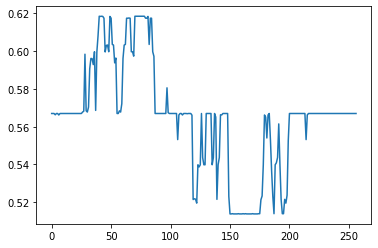

In [ ]:
plt.plot(y_test_pred)

In [ ]:
#正規化されている予測データを戻す(テストデータ)
y_j = min_global + y_test_pred * (max_global -min_global) 

In [ ]:
len(close), len(y_j)

(257, 257)

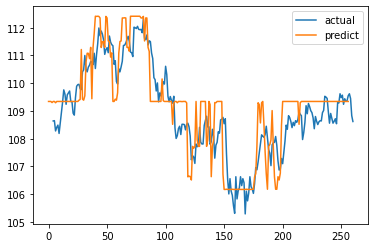

In [ ]:
plt.plot(close["close"],label="actual")
plt.plot(y_j,label="predict")
plt.legend()

In [ ]:
renorm_mae = format(mean_squared_error(close["close"],y_j), ".10f")
print(renorm_mae)

0.5160925065


In [ ]:
data = pd.concat([df_train,df_test])
df_train

,Results,USD/JPY Close,USD/JPY High,USD/JPY Low
0,Average,106.462,106.935,105.964
1,Minimum,75.720,76.000,75.550
2,Maximum,134.780,135.150,134.100
3,Std,13.543,13.574,13.505
4,# In Calc,4956,4956,4956
...,...,...,...,...
4957,2018-12-25,110.25,110.47,110.01
4958,2018-12-26,111.17,111.19,110.14
4959,2018-12-27,110.71,111.37,110.46
4960,2018-12-28,110.39,111.03,110.22


In [ ]:
len(X_train),len(X_test)

(4951, 257)